# Training a Model on Encrypted Data

In [1]:
import sys
import torch
import torchvision
import matplotlib.pyplot as plt


# python 3.7 is required
assert sys.version_info[0] == 3 and sys.version_info[1] == 7, "python 3.7 is required"

import crypten
crypten.init()

%matplotlib inline

## MNIST

In [2]:
digits = torchvision.datasets.MNIST(root='/tmp/data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

digits_test = torchvision.datasets.MNIST(root='/tmp/data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

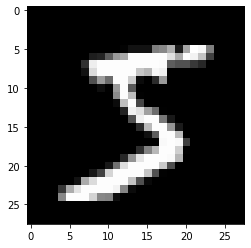

In [3]:
plt.imshow(digits[0][0][0], cmap='gray', interpolation='none')

In [4]:
print("label for image is ", digits[0][1])

label for image is  5


## Preprocess Into Tensors

In [5]:
def take_samples(digits, n_samples=1000):
    """Returns images and labels based on sample size"""
    images, labels = [], []

    for i, digit in enumerate(digits):
        if i == n_samples:
            break
        image, label = digit
        images.append(image)
        label_one_hot = torch.nn.functional.one_hot(torch.tensor(label), 10)
        labels.append(label_one_hot)

    images = torch.cat(images)
    labels = torch.stack(labels)
    return images, labels
    

In [6]:
images, labels = take_samples(digits, n_samples=100)
images = images.unsqueeze(1)

In [7]:
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 10])


In [8]:
images_enc = crypten.cryptensor(images)
labels_enc = crypten.cryptensor(labels)

In [9]:
images_enc[0]

MPCTensor(
	_tensor=tensor([[[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,

In [10]:
# test set
images_test, labels_test = take_samples(digits_test, n_samples=20)
images_test_enc = crypten.cryptensor(images_test)
labels_test_enc = crypten.cryptensor(labels_test)

## Logistic Regression Model

(multiclass logistic regression)

In [11]:
class LogisticRegression(crypten.nn.Module):
    
    def __init__(self):
        super().__init__()
        # images are 28x28 pixels
        self.linear = crypten.nn.Linear(28 * 28, 10)
        
    def forward(self, x):
        return self.linear(x.flatten(start_dim=1))
        
    

In [12]:
model = LogisticRegression().encrypt()

In [13]:
model(images_enc)

MPCTensor(
	_tensor=tensor([[ -7212,  -4832, -18332,  -1289, -14345, -10329, -20953,  17165, -26486,
           7973],
        [ -4941,  14792, -17722,  21735,  -9983,   4587,  -4442,  11390, -44190,
            122],
        [ 11571,  17364,    995,  12531, -13151,  13358,  -6799,  -5498, -10863,
         -12377],
        [ 12576,  -8088, -12991,  -4375,  -6995,  -5857,   2563,   3591, -20752,
            685],
        [ -2223,   4062,  -8420,   5543, -14815,  12751,   5019,  17012, -18646,
          13673],
        [ -8783,   8678, -12389,  17346,   1583,  22358,  -4514,   4856, -41324,
           7442],
        [  1564,  10381,   8001,   -848, -13249,  16488,   7019,  14232,   -692,
          17547],
        [  5243,  23551, -15260,  28311,  -8729,  14170, -14053,   1791, -33591,
          11378],
        [  2616,   -294,    833,  -8909, -18784,  12657,   8126,  17566,   6428,
          17520],
        [  3399,   4754,   -566,  12797,   6129,  14565,   6011,  12069, -16259,
        

### Train Model on Encrypted Images

In [14]:
def train_model(model, X, y, epochs=10, learning_rate=0.05):
    criterion = crypten.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

In [15]:
model = train_model(model, images_enc, labels_enc)

epoch 0 loss: 2.3475341796875
epoch 1 loss: 2.243408203125
epoch 2 loss: 2.1518096923828125
epoch 3 loss: 2.0686492919921875
epoch 4 loss: 1.9932098388671875
epoch 5 loss: 1.922882080078125
epoch 6 loss: 1.857452392578125
epoch 7 loss: 1.79583740234375
epoch 8 loss: 1.7375640869140625
epoch 9 loss: 1.6826324462890625


### Decrypt Prediction

In [16]:
prediction = model(images_enc[3].unsqueeze(0))

In [17]:
prediction.get_plain_text().argmax()

tensor(1)

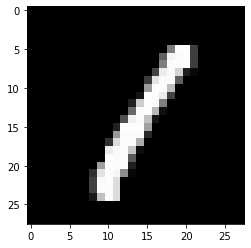

In [18]:
plt.imshow(images[3, 0], cmap='gray', interpolation='none')

### Test Model Accuracy

In [19]:
def avg_test_accuracy(model, X, y):    
    output = model(X).get_plain_text().softmax(0)
    predicted = output.argmax(1)
    labels = y.get_plain_text().argmax(1)
    correct = (predicted == labels).sum().float()
    return float(correct / y.shape[0])

In [20]:
avg_test_accuracy(model, images_enc, labels_enc)

0.8799999952316284

## Training a CNN

based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In [21]:
class CNN(crypten.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = crypten.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = crypten.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = crypten.nn.Dropout2d(0.25)
        self.dropout2 = crypten.nn.Dropout2d(0.5)
        self.fc1 = crypten.nn.Linear(9216, 128)
        self.fc2 = crypten.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = x.relu()
        x = self.conv2(x)
        x = x.relu()
        x = x.max_pool2d(2)
        x = self.dropout1(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = x.relu()
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [22]:
model = CNN().encrypt()

In [23]:
print(images_enc.size())
x = images_enc[0].view(1, 1, 28, 28)
print(x.shape)
model(x)

torch.Size([100, 1, 28, 28])
torch.Size([1, 1, 28, 28])


MPCTensor(
	_tensor=tensor([[ 2551,  4465,  1717, -1723,   966, -7681,   494,  -457,   411,  3919]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [24]:
model = train_model(model, images_enc[:10, ], labels_enc[:10,], epochs=3)

epoch 0 loss: 2.272796630859375
epoch 1 loss: 2.2662353515625
epoch 2 loss: 2.2158050537109375


In [25]:
prediction = model(images_enc[3].unsqueeze(0)).argmax()

# Importing PyTorch Models

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [27]:
pytorch_model = PyTorchModel()

In [28]:
dummy_input = torch.empty(images.shape)
crypten_model = crypten.nn.from_pytorch(pytorch_model, dummy_input)
crypten_model.encrypt()

/Users/brianknott/Desktop/CrypTen/crypten/nn/onnx_converter.py:161: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1616554799287/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  param = torch.from_numpy(numpy_helper.to_array(node))


Graph encrypted module

In [29]:
prediction = crypten_model(images_enc[3].unsqueeze(0))
print(prediction)

MPCTensor(
	_tensor=tensor([[-156495, -149670, -157653, -148411, -152466, -145310, -148855, -147026,
         -149449, -149893]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)


In [30]:
print(prediction.get_plain_text())

tensor([[-2.3879, -2.2838, -2.4056, -2.2646, -2.3264, -2.2173, -2.2713, -2.2434,
         -2.2804, -2.2872]])


In [31]:
prediction.get_plain_text().argmax()

tensor(5)

In [32]:
crypten_model = train_model(crypten_model, images_enc[:10, ], labels_enc[:10,], epochs=3)

epoch 0 loss: 2.3539276123046875
epoch 1 loss: 2.28973388671875
epoch 2 loss: 2.2553558349609375
